In [1]:
# i have multiple things going in, and i need to seperate each and every one of them. i need to seperate all the classes from the image(ie. clay mineral + heavy mineral + dense mineral + light mineral)
# Accuracy is not good measure in U-net, as say i have a image of cell which actually occupies only 3% of frame, anything else is abckgound, the model showed 98% accuracy for blank background(which is useless), but not for the cell. So, accuracy is problematic for imbalanced class.
# thats why IOU(intersection over union) Score can be a great measure --> The IoU value ranges from 0 to 1, where 0 indicates no overlap between the boxes(0% accuracy), and 1 represents complete overlap(100% accuracy, practically not possible) or identical regions. Higher IoU values indicate greater similarity or agreement between the two bounding boxes.

# into the graph where training and validation (loss/accuracy) graph merges/intersects there, that epoch is optimal to train;

In [5]:
# extracting images from the stack

import numpy as np
import tifffile as tiff
from patchify import patchify 
from matplotlib import pyplot as plt

large_image_stack = tiff.imread(r"D:\Deep Learning\U Net Basics\Multiclass segmentation\sandstone_data_for_ML\full_labels_for_deep_learning\128_patches\images_as_128x128_patches.tif")
large_mask_stack = tiff.imread(r"D:\Deep Learning\U Net Basics\Multiclass segmentation\sandstone_data_for_ML\full_labels_for_deep_learning\128_patches\masks_as_128x128_patches.tif")
a = 0
for img in range(large_image_stack.shape[0]): #large_image_stack.shape[0]-->165, iterate through all 165 images;
    broken_image = large_image_stack[img] # getting a individual 1024x768 large iamge from the stack at each iteration;
    tiff.imwrite(r'D:\Deep Learning\U Net Basics\Multiclass segmentation\sandstone_data_for_ML\full_labels_for_deep_learning\128_patches\images/' + 'images_' + str(a) + '.tif', broken_image)
    a = a+1

In [6]:
b = 0
for img1 in range(large_mask_stack.shape[0]): #large_image_stack.shape[0]-->165, iterate through all 165 images;
    broken_mask = large_mask_stack[img1] # getting a individual 1024x768 large iamge from the stack at each iteration;
    tiff.imwrite(r'D:\Deep Learning\U Net Basics\Multiclass segmentation\sandstone_data_for_ML\full_labels_for_deep_learning\128_patches\masks/' + 'masks_' + str(b) + '.tif', broken_mask)
    b = b+1

In [8]:
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [9]:
# if resizing needed,
SIZE_X = 128
SIZE_Y = 128

n_classes = 4

In [12]:
train_images = []
for directory_path in  glob.glob(r"D:\Deep Learning\U Net Basics\Multiclass segmentation\sandstone_data_for_ML\full_labels_for_deep_learning\128_patches\images/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        img = cv2.imread(img_path, 0) # reading as grey level;
        # img = cv2.resize(img, SIZE_X, SIZE_Y) --> resize if needed;
        train_images.append(img)

train_images = np.array(train_images) # converting into numpy array; 


train_masks = []
for directory_path in  glob.glob(r"D:\Deep Learning\U Net Basics\Multiclass segmentation\sandstone_data_for_ML\full_labels_for_deep_learning\128_patches\masks/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.tif")):
        mask = cv2.imread(mask_path, 0) # reading as grey level;
        # img = cv2.resize(img, SIZE_X, SIZE_Y) --> resize if needed;
        train_masks.append(mask)

train_masks = np.array(train_masks) 

In [13]:
train_masks.shape

(1600, 128, 128)

In [14]:
np.unique(train_masks) # i have classes -->[1, 2, 3, 4] --> but, the machine learning libraries(ie. IOU Score) expect to get classes0, 1, 2, 3; so, i need to convert 1, 2, 3, 4 into 0, 1, 2, 3;

array([1, 2, 3, 4], dtype=uint8)

In [15]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder() # LabelEncoder only works on 1D(single vector), so i need to convert the list(train_image + train_maks) from 3D(1600, 128, 128) to single vector, then change the classes names and then again change back to 3D;
n, h, w = train_masks.shape # n --> numbers of images, h --> height, w --> weights; 

train_masks_reshaped = train_masks.reshape(-1, 1) # converting into single vector;
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped) # changing from (1, 2, 3, 4) to (0, 1, 2, 3);
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w) # again, converting the single vector to 3D(orig. shape);

np.unique(train_masks_encoded_original_shape)

C:\python_arpan\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3], dtype=int64)

In [43]:
train_images = np.expand_dims(train_images, axis=3) # increase the dimension by 1, that value would be 3;
train_images = normalize(train_images, axis=1) # data normalization --> all my unsignedint8 be converted into float;

In [45]:
train_images.shape

(1600, 128, 128, 1)

In [46]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3) # expanding the dimension by 1 of value 3;

In [47]:
# spliting into test-train subset;
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
#X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

print('Class Values in the data set : ', np.unique(y_train))

Class Values in the data set :  [0 1 2 3]


In [48]:
# converting into catagorical - basically one-hot-encoding;
from keras.utils import to_categorical

train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes)) # just a sanity check, no need to done into this dataset;

# same thing for y_test;
test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))


In [50]:
from sklearn.utils import class_weight # my dataset is extensively unbalanced, as class 1 --> grey part = is the largest covers almost 95-96% frame, whereas class 3 --> white part = covers only <1% frame; all the pixels are not equally seperated;
# class_weight --> this method gonna help us to make it balanced;

class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(train_masks_reshaped_encoded), y = train_masks_reshaped_encoded)
print('Class Weights : ', class_weights) # 0.32786918 --> as class2 is huge, thats why i need to amke it down to .3, 9.30640739 --> class3 insanely low, thats why i multiplied it with 9 to make balanced; 

Class Weights :  [1.93354786 3.07345989 0.32786918 9.30640739]


In [51]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [53]:
%run unet-normal.ipynb
def get_model():
    return simple_unet_model(n_classes = n_classes, IMG_HEIGHT = IMG_HEIGHT, IMG_WIDTH = IMG_WIDTH, IMG_CHANNELS = IMG_CHANNELS) # n_classes --> no. of classes, as this is a muticlass segmentation, i have multiple classes, (Pixel value 1 = Background / Air Pixel), (value 2 = Clay Pixel), (value 3 = Quartz Pixel), (value 4 = Pyrite);
model = get_model()
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         160       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 16)         2320      ['dropout[0][0]']             
                                                                                              

 conv2d_transpose_3 (Conv2D  (None, 128, 128, 16)         2064      ['conv2d_15[0][0]']           
 Transpose)                                                                                       
                                                                                                  
 concatenate_3 (Concatenate  (None, 128, 128, 32)         0         ['conv2d_transpose_3[0][0]',  
 )                                                                   'conv2d_1[0][0]']            
                                                                                                  
 conv2d_16 (Conv2D)          (None, 128, 128, 16)         4624      ['concatenate_3[0][0]']       
                                                                                                  
 dropout_8 (Dropout)         (None, 128, 128, 16)         0         ['conv2d_16[0][0]']           
                                                                                                  
 conv2d_17

                                                                                                  
 dropout_6 (Dropout)         (None, 32, 32, 64)           0         ['conv2d_12[0][0]']           
                                                                                                  
 conv2d_13 (Conv2D)          (None, 32, 32, 64)           36928     ['dropout_6[0][0]']           
                                                                                                  
 conv2d_transpose_2 (Conv2D  (None, 64, 64, 32)           8224      ['conv2d_13[0][0]']           
 Transpose)                                                                                       
                                                                                                  
 concatenate_2 (Concatenate  (None, 64, 64, 64)           0         ['conv2d_transpose_2[0][0]',  
 )                                                                   'conv2d_3[0][0]']            
          

In [55]:
# training
history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=10, 
                    validation_data=(X_test, y_test_cat), 
                    #class_weight=class_weights, # in this case this line is not greaty modifing the results, and a s being computationaly heavy i opt. out;
                    shuffle=False)

model.save('sandstone_after_2_epochs.hdf5')

Epoch 1/10
90/90 [==============================] - 150s 2s/step - loss: 0.3184 - accuracy: 0.8848 - val_loss: 0.2449 - val_accuracy: 0.9112
Epoch 2/10
90/90 [==============================] - 158s 2s/step - loss: 0.2600 - accuracy: 0.9090 - val_loss: 0.2109 - val_accuracy: 0.9225
Epoch 3/10
90/90 [==============================] - 159s 2s/step - loss: 0.2251 - accuracy: 0.9217 - val_loss: 0.1952 - val_accuracy: 0.9294
Epoch 4/10
90/90 [==============================] - 159s 2s/step - loss: 0.2005 - accuracy: 0.9304 - val_loss: 0.1752 - val_accuracy: 0.9371
Epoch 5/10
90/90 [==============================] - 156s 2s/step - loss: 0.1874 - accuracy: 0.9351 - val_loss: 0.1685 - val_accuracy: 0.9399
Epoch 6/10
90/90 [==============================] - 157s 2s/step - loss: 0.1762 - accuracy: 0.9387 - val_loss: 0.1582 - val_accuracy: 0.9435
Epoch 7/10
90/90 [==============================] - 166s 2s/step - loss: 0.1655 - accuracy: 0.9427 - val_loss: 0.1531 - val_accuracy: 0.9446
Epoch 8/10
90

In [56]:
#Evaluate the model and calculating the accuracy
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")


5/5 [==============================] - 4s 629ms/step - loss: 0.1397 - accuracy: 0.9492
Accuracy is =  94.91935968399048 %


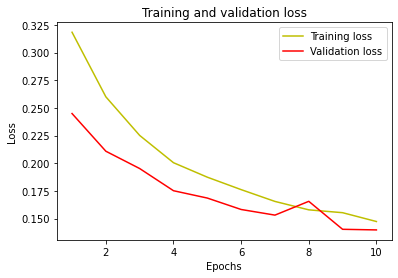

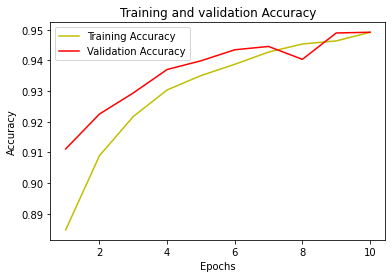

In [58]:
#plot the training and validation accuracy and loss at each epoch

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [59]:
# IOU
y_pred=model.predict(X_test) # just showing me probabilities, for each one;
y_pred_argmax=np.argmax(y_pred, axis=3) # i need to convert that into catagorical, keep the max value of these probabilities --> argmax finds the argument that gives the maximum value. it finds the class with maximum probability;

5/5 [==============================] - 3s 587ms/step


In [60]:
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax) # y_test[:,:,:,0] --> (the ground truth), y_pred_argmax --> (the prediction);
print("Mean IoU =", IOU_keras.result().numpy()) # .result() --> shows into a human-structured format;
# calculating the IOU

Mean IoU = 0.8094991


In [61]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU) # IoU for class2 is:  0.542573, that means, i need to increase this weight to make a better segmentation;
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

[[3.239640e+05 1.870600e+04 1.408000e+04 2.000000e+00]
 [9.506000e+03 1.258650e+05 6.633200e+04 4.000000e+00]
 [4.332000e+03 1.156500e+04 1.979609e+06 4.804000e+03]
 [0.000000e+00 0.000000e+00 3.855000e+03 5.881600e+04]]
IoU for class1 is:  0.8741844
IoU for class2 is:  0.542573
IoU for class3 is:  0.9496454
IoU for class4 is:  0.8715935


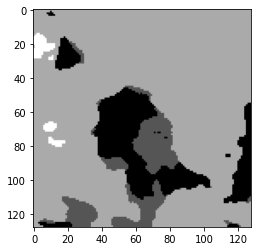

In [62]:
# showing one image to understand how the dataset looks;
plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')

1/1 [==============================] - 0s 65ms/step


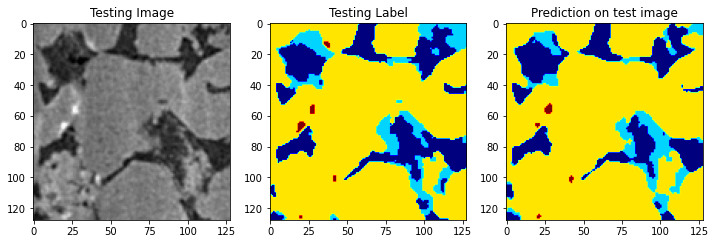

In [69]:
# predict on a random image
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()